In [208]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')

sys.path.insert(0, '/home/yuncong/project/cython-munkres-wrapper/build/lib.linux-x86_64-2.7')
from munkres import munkres

sys.path.append('/home/yuncong/Brain/pipeline_scripts')
import utilities2014
reload(utilities2014)
from utilities2014 import *

import os
import time

# os.environ['GORDON_DATA_DIR'] = '/home/yuncong/project/DavidData2014tif/'
# os.environ['GORDON_REPO_DIR'] = '/home/yuncong/Brain'
# os.environ['GORDON_RESULT_DIR'] = '/home/yuncong/csd395/DavidData2014results/'
# os.environ['GORDON_LABELING_DIR'] = '/home/yuncong/project/DavidData2014labelings/'

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import average, fcluster, leaders, complete, single, dendrogram

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.util import img_as_float, pad
from skimage.morphology import disk
from skimage.filter.rank import gradient

from sklearn.preprocessing import normalize

from collections import defaultdict, Counter
from itertools import combinations, chain, product

import networkx
from networkx import from_dict_of_lists, dfs_postorder_nodes

import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
def boundary_distance(b1, b2, sc1=None, sc2=None, loc_thresh=1500):
    '''
    Compute the distance between two boundaries.
    Each tuple consists of (edgeSet, interior_texture, exterior_textures, points, center)
    
    Parameters
    ----------
    b1 : tuple
    b2 : tuple
    sc1 : #points-by-32 array
        pre-computed shape context descriptor
    sc2 : #points-by-32 array
        pre-computed shape context descriptor
    '''
    
    _, interior_texture1, exterior_textures1, points1, center1 = b1
    _, interior_texture2, exterior_textures2, points2, center2 = b2
    if sc1 is not None:
        assert len(sc1) == points1.shape[0], 'number mismatch %d %d'%(len(sc1), points1.shape[0])
    
    if sc2 is not None:
        assert len(sc2) == points2.shape[0], 'number mismatch %d %d'%(len(sc2), points2.shape[0])

    if loc_thresh is None:
        D_loc = 0
    else:
        # compute location difference
        d_loc = np.linalg.norm(center1 - center2)
        D_loc = np.maximum(0, d_loc - 500)
        if d_loc > loc_thresh:
            return np.inf, np.inf, np.inf, np.inf, np.inf
    
    n1 = len(points1)
    n2 = len(points2)
    if max(n1,n2) > min(n1,n2) * 3:
        return np.inf, np.inf, np.inf, np.inf, np.inf
    
    # compute interior texture difference
    D_int = chi2(interior_texture1, interior_texture2)
#     D_ext = hausdorff_histograms(exterior_textures1, exterior_textures2, metric=chi2)

    # compute shape difference, exterior texture difference
    D_shape, matches = shape_context_score(points1, points2, descriptor1=sc1, descriptor2=sc2)
#         D_ext = np.mean([chi2(exterior_textures1[i], exterior_textures2[j]) for i, j in matches])
    
    bg_match = 0

    if len(matches) == 0:
        D_ext = np.inf
    else:
        ddd = []
        for i, j in matches:
            # -1 vs -1
            if np.isnan(exterior_textures1[i]).all() and np.isnan(exterior_textures2[j]).all():
                s = 0
                bg_match += 1
                ddd.append(s)
            # non -1 vs non -1
            elif not np.isnan(exterior_textures1[i]).all() and not np.isnan(exterior_textures2[j]).all():
                s = chi2(exterior_textures1[i], exterior_textures2[j])
                if OUTPUT:
                    print 'exterior', i,j,s
                ddd.append(s)
            # -1 vs non -1
            else:
                ddd.append(2.)

        if len(ddd) == 0:
            D_ext = np.inf
        elif len(ddd) == bg_match:
            D_ext = 2.
        else:
            D_ext = np.mean(ddd)
    
    D_shape = D_shape * .01

    # weighted average of four terms
    d = D_int + D_ext + D_shape
    
    return d, D_int, D_ext, D_shape, D_loc


In [3]:
def rigid_transform_from_pairs(X,Y):
    '''
    X, Y are n-by-2 matrices
    Reference: http://nghiaho.com/?page_id=671
    '''

    n = X.shape[0]
    assert X.shape[0] == Y.shape[0], 'two point sets have different size'
    assert n >= 2, 'rgiid transform estimate needs at least two points'
    
    X = X.T
    Y = Y.T
    
    Xcentroid = X.mean(axis=1)
    Ycentroid = Y.mean(axis=1)
    
    Xcentered = X - Xcentroid[:, np.newaxis]
    Ycentered = Y - Ycentroid[:, np.newaxis]
    
    U, S, V = np.linalg.svd(np.dot(Xcentered, Ycentered.T))
    R = np.dot(V, U.T)
    d = np.linalg.det(R)
    if d < 0:
        R[1] *= -1
    angle = np.arctan2(R[1,0], R[0,0])
    t = Ycentroid - np.dot(R, Xcentroid)
    
    T = np.eye(3)
    T[:2, :2] = R
    T[:2, 2] = t
   
    return T, angle

def rigid_transform_to(pts1, T):
    pts1_trans = np.dot(T, np.column_stack([pts1, np.ones((pts1.shape[0],))]).T).T
#     pts1_trans = pts1_trans[:,:2]/pts1_trans[:,-1][:,np.newaxis]
    return pts1_trans[:,:2]

In [4]:
import random

def ransac_rigid_transform(X, Y, sample_size=3):
    
    n = X.shape[0]
    err_all = []
    T_all = []
    inlier_all = []
    for si in range(10):    
#         print 'iter', si
        s = random.sample(range(n), min(sample_size, n))
        for ri in range(10):
            Xs = X[s]
            Ys = Y[s]
            T, _ = rigid_transform_from_pairs(Xs, Ys)
            Xst = rigid_transform_to(Xs, T)
            d = Xst - Ys
            errs = np.sqrt(np.sum(d**2, axis=1))
            s2 = list(set(s) | set(np.where(errs < 500)[0]))
#             print ri, np.mean(errs), len(s2)
            if len(s2) == len(s):
                break
            else:
                s = s2
        inlier_all.append(s)
        err_all.append(np.mean(errs))
        T_all.append(T)
    
    best = np.argmin(err_all)
#     print err_all[best]
#     print best
    return T_all[best], inlier_all[best]

In [5]:
from scipy.misc import comb

def ransac_compute_rigid_transform(Dm, pts1, pts2, confidence_thresh=.01, ransac_iters=20, sample_size=5,
                                  matching_iter=10, n_neighbors=10):

#     q = time.time()
    
    high_confidence_thresh = np.sort(Dm.flat)[int(confidence_thresh * np.size(Dm))]
#     print 'high_confidence_thresh', high_confidence_thresh
    
    N1 = len(pts1)
    N2 = len(pts2)
    
    rs, cs = np.where(Dm < high_confidence_thresh)
    high_confidence_pairs = np.c_[rs,cs]
    
    if len(high_confidence_pairs) == 0:
        return None, [], None, np.inf
    
    if OUTPUT:
        print 'high_confidence_pairs', high_confidence_pairs
    
#     from itertools import combinations
#     possible_samples = list(combinations(high_confidence_pairs, sample_size))
#     random.shuffle(possible_samples)
    
#     n_possible_samples = len([t for t in combinations(high_confidence_pairs, sample_size) 
#                         if allunique([tt[0] for tt in t]) and allunique([tt[1] for tt in t])])
#     print 'n_possible_samples', len(possible_samples)
#     random.shuffle(possible_samples)

#     print 'comb', time.time() - q

#     return
    
    p1s = np.sort(list(set(rs)))
    p2s = np.sort(list(set(cs)))
    n1 = len(p1s)
    n2 = len(p2s)
    
    if n1 < sample_size or n2 < sample_size:
        return None, [], None, np.inf
    
    offsets = []
    scores = []
    matches_list = []
    samples_list = []
    
    sample_counter = 0
    n_possible_samples = int(comb(len(high_confidence_pairs), sample_size, exact=False))

#     n_possible_samples = len(possible_samples)
    for ri in range(min(ransac_iters, n_possible_samples)):
        
        samples = []
        
        for tt in range(100):
#             s = possible_samples[sample_counter]
            s = random.sample(high_confidence_pairs, sample_size)
            sample_counter += 1
            w1, w2 = zip(*s)
            if len(set(w1)) == len(w1) and len(set(w2)) == len(w2):
                samples = s
                break

#         samples = np.array(possible_samples[ri])

        if OUTPUT:
            print '\nsamples', ri, samples
        
        X = pts1[[s[0] for s in samples]]
        Y = pts2[[s[1] for s in samples]]
                
        # generate transform hypothesis
        T, angle = rigid_transform_from_pairs(X, Y)
        if np.abs(angle) > np.pi/4:
            if OUTPUT:
                print 'angle too wide', np.rad2deg(angle)
            continue
        
        # apply transform hypothesis
        pts1_trans = rigid_transform_to(pts1, T)
        
        # iterative closest point association
        matches = None
        matches_prev = None
        
        for mi in range(matching_iter):
  
            # given transform, find matching

#             t1 = time.time()
        
#             b = time.time()
    
            Dh = cdist(pts1_trans, pts2, metric='euclidean')
            Dargmin1 = Dh.argsort(axis=1)
            Dargmin0 = Dh.argsort(axis=0)
#             print 'cdist', time.time() - b
        
#             b = time.time()
            
            D2 = Dh.copy()
            D2[np.arange(N1)[:,np.newaxis], Dargmin1[:,n_neighbors:]] = 999
            D2[Dargmin0[n_neighbors:,:], np.arange(N2)[np.newaxis,:]] = 999
            D_hc_pairs = D2[p1s[:,np.newaxis], p2s]
                
#             D_hc_pairs = 9999 * np.ones((n1, n2))
#             for i,j in high_confidence_pairs:
#                 if j in Dargmin1[i,:10] and i in Dargmin0[:10,j]:
#                     ii = p1s.index(i)
#                     jj = p2s.index(j)
#                     D_hc_pairs[ii, jj] = Dh[i,j]

#             print 'D_hc_pairs', time.time() - b

            if matches is not None:
                matches_prev = matches
            
#             b = time.time()
            matches_hc_pairs = np.array(zip(*np.nonzero(munkres(D_hc_pairs))))
#             print 'munkres', time.time() - b, mi
            
#             b = time.time()

#                 print [(p1s[ii], p2s[jj]) for (ii,jj) in matches_hc_pairs]
            matches = np.array([(p1s[ii], p2s[jj]) for (ii,jj) in matches_hc_pairs
                                if D_hc_pairs[ii, jj] != 999])
            # some 9999 edges will be included, the "if" above removes them
#             print 'matches', time.time() - b
        
            expanded_matches = []
            matches1 = set([i for i,j in matches])
            matches2 = set([j for i,j in matches])
            rem1 = set(range(N1)) - matches1
            rem2 = set(range(N2)) - matches2
            add1 = set([])
            add2 = set([])
            for i in rem1:
                for j in rem2:
                    if j in Dargmin1[i,:3] and i in Dargmin0[:3,j] and i not in add1 and j not in add2:
                        add1.add(i)
                        add2.add(j)
                        expanded_matches.append((i,j))

            if len(expanded_matches) > 0 and len(matches) > 0 :
                matches = np.vstack([matches, np.array(expanded_matches)])
    
            if OUTPUT:
#                 print 'considered pairs', w
#                 print 'matches', [(i,j) for i,j in matches
                q1, q2 = np.where(D_hc_pairs < 999)
                w = zip(*[p1s[q1], p2s[q2]])
                print 'matches', len(matches), '/', 'considered pairs', len(w), '/', 'all hc pairs', len(high_confidence_pairs)

#             t2 = time.time()
            
            if len(matches) < 3:
                s = np.inf
                break
            else:
                xs1 = pts1_trans[matches[:,0], 0]
                x_coverage1 = float(xs1.max() - xs1.min()) / (pts1_trans[:,0].max() - pts1_trans[:,0].min())
                ys1 = pts1_trans[matches[:,0], 1]
                y_coverage1 = float(ys1.max() - ys1.min()) / (pts1_trans[:,1].max() - pts1_trans[:,1].min())
                
                xs2 = pts2[matches[:,1], 0]
                x_coverage2 = float(xs2.max() - xs2.min())/ (pts2[:,0].max() - pts2[:,0].min())
                ys2 = pts2[matches[:,1], 1]
                y_coverage2 = float(ys2.max() - ys2.min())/ (pts2[:,1].max() - pts2[:,1].min())
                
                coverage = .5 * x_coverage1 * y_coverage1 + .5 * x_coverage2 * y_coverage2
                
                s = Dh[matches[:,0], matches[:,1]].mean() / coverage**2    
#             s = .5 * Dm[Dh.argmin(axis=0), np.arange(len(pts2))].mean() + .5 * Dm[np.arange(len(pts1)), Dh.argmin(axis=1)].mean()            
#             s = np.mean([np.mean(Dh.min(axis=0)), np.mean(Dh.min(axis=1))])
    
            X = pts1[matches[:,0]]
            Y = pts2[matches[:,1]]

            T, angle = rigid_transform_from_pairs(X, Y)
            if np.abs(angle) > np.pi/4:
                break

            pts1_trans = rigid_transform_to(pts1, T)
            
            if matches_prev is not None and all([(i,j) in matches_prev for i,j in matches]):
                break
                
#             print 'coverage and remaining', mi, time.time() - t2
        
#             print mi, time.time() - t1
                
#         Dh = cdist(pts1_trans, pts2, metric='euclidean')
#         Dargmin1 = Dh.argsort(axis=1)
#         Dargmin0 = Dh.argsort(axis=0)
        
#         expanded_matches = []
#         matches1 = set([i for i,j in matches])
#         matches2 = set([j for i,j in matches])
#         rem1 = set(range(N1)) - matches1
#         rem2 = set(range(N2)) - matches2
#         add1 = set([])
#         add2 = set([])
#         for i in rem1:
#             for j in rem2:
#                 if j in Dargmin1[i,:3] and i in Dargmin0[:3,j] and i not in add1 and j not in add2:
#                     add1.add(i)
#                     add2.add(j)
#                     expanded_matches.append((i,j))
                    
#         if len(expanded_matches) > 0 and len(matches) > 0 :
#             matches = np.vstack([matches, np.array(expanded_matches)])
        
#         print matches
                            
        samples_list.append(samples)
        offsets.append(T)
        matches_list.append(matches)
        scores.append(s)
    
#         print matches
#         print s
#         plot_two_pointsets(pts1_trans[:,::-1]*np.array([1,-1]), pts2[:,::-1]*np.array([1,-1]), 
#                    center1=False, center2=False,
#                    text=True, matchings=matches)
            
    if len(scores) > 0:
        best_i = np.argmin(scores)

        best_score = scores[best_i]
        best_T = offsets[best_i]
        best_sample = samples_list[best_i]
        best_matches = matches_list[best_i]    
    
        return best_T, best_matches, best_sample, best_score
    else:
        return None, [], None, np.inf


In [6]:
def shape_context_score(pts1, pts2, descriptor1=None, descriptor2=None):

    if descriptor1 is None:
        descriptor1 = compute_shape_context_descriptors(pts1, dist_limit=.8)
    
    if descriptor2 is None:
        descriptor2 = compute_shape_context_descriptors(pts2, dist_limit=.8)
        
    descriptor_dists = cdist(descriptor1, descriptor2, metric='euclidean')
        
#     b = time.time()

    T, best_match, best_sample, best_score = ransac_compute_rigid_transform(descriptor_dists, pts1, pts2, 
                                                                            ransac_iters=50, confidence_thresh=0.03, 
                                                                            sample_size=3, matching_iter=10,
                                                                           n_neighbors=3)
#     print 'ransac_compute_rigid_transform', time.time() - b

    
    if T is None and len(best_match)==0:
        return np.inf, []
    
    if OUTPUT:
        print 'best_match', best_match
        print 'best_sample', best_sample
        print 'best_score', best_score

    return best_score, best_match

In [7]:
def euclidean_dists_angles(points):
    """Returns symmetric pairwise ``dists`` and ``angles`` arrays."""
    
    n = len(points)
    dists = squareform(pdist(points, 'euclidean'))

    xd = -np.subtract.outer(points[:,0], points[:,0])
    yd = -np.subtract.outer(points[:,1], points[:,1])
    angles = np.arctan2(yd,xd)

    closest_neighbor = dists.argsort(axis=1)[:,1]
    tangent_vectors = points[closest_neighbor] - points
    tangent_angles = np.arctan2(tangent_vectors[:,1], tangent_vectors[:,0])

    angles = angles - tangent_angles[:, np.newaxis]
    angles = angles%(2*np.pi)
    angles[angles > np.pi] = angles[angles > np.pi] - 2*np.pi

    return dists, angles

def compute_r_theta_bins(n_radial_bins=5, n_polar_bins=12, dist_limit=1.):
    """
    Generate radius-theta bins for the shape context histogram.
    
    Args:
        n_radial_bins (int): number of radial bins
        n_polar_bins (int): number of polar bins
        dist_limit (float): between 0 and 1

    Returns:
        (float array, float array): (r_array, theta_array)

    """
        
    base = 10.    
    r_array = dist_limit * (np.logspace(0, 1, n_radial_bins + 1, base=10) - 1)[1:] / (base-1)
    theta_array = np.linspace(-np.pi, np.pi, n_polar_bins + 1)[1:]
    
    return r_array, theta_array

def compute_shape_context_descriptors(pts, n_radial_bins=5, n_polar_bins=12, 
                                      dist_limit=1., density=True):

    dists, angles = euclidean_dists_angles(pts)
    n_points = dists.shape[0]
    
    r_array, theta_array = compute_r_theta_bins(n_radial_bins, n_polar_bins, dist_limit)
    
    descriptors_mat = np.zeros((n_points, n_radial_bins, n_polar_bins), dtype=np.int)

    dists = dists / dists.max()

    for i in range(n_points):
        for j in range(i + 1, n_points):
            
            if dists[i, j] >= r_array[-1]:
                continue

            r_idx = np.searchsorted(r_array, dists[i, j])
            theta_idx = np.searchsorted(theta_array, angles[i, j])

            descriptors_mat[i, r_idx, theta_idx] += 1

            theta_idx = np.searchsorted(theta_array, angles[j, i])
            descriptors_mat[j, r_idx, theta_idx] += 1

    descriptors = descriptors_mat.reshape(descriptors_mat.shape[0], -1)

    if density:
        descriptors = normalize(descriptors.astype(np.float), axis=1)
    
    return descriptors

In [10]:
from subprocess import check_output

s = check_output("ssh gordon.sdsc.edu ls %s" % os.path.join(os.environ['GORDON_DATA_DIR'], 'RS141', 'x5'), shell=True)
slide_indices = [int(f) for f in s.split('\n') if len(f) > 0]
n_slice = len(slide_indices)
last_sec = max(slide_indices)

dms_temp = [ DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=sec_ind) for sec_ind in slide_indices]
# for dm in dms1:
#     dm._load_image()
    
boundary_models_temp = [dm.load_pipeline_result('boundaryModels', 'pkl') for dm in dms_temp]

s = check_output("ssh gordon.sdsc.edu ls %s" % os.path.join(os.environ['GORDON_DATA_DIR'], 'RS140', 'x5'), shell=True)
slide_indices = [int(f) for f in s.split('\n') if len(f) > 0]
n_slice = len(slide_indices)
last_sec = max(slide_indices)

dms_subj = [ DataManager(generate_hierarchy=False, stack='RS140', resol='x5', section=sec_ind) for sec_ind in slide_indices]
# for dm in dms2:
#     dm._load_image()
boundary_models_subj = [dm.load_pipeline_result('boundaryModels', 'pkl') for dm in dms_subj]

In [11]:
lm_groups_temp = dms_temp[0].load_pipeline_result('landmarkGroups', 'pkl')
lm_groups_subj = dms_subj[0].load_pipeline_result('landmarkGroups', 'pkl')

In [96]:
def cdist_general(xs, ys, metric):
    vals = Parallel(n_jobs=16, max_nbytes=1e6)(delayed(metric)(x, y) for x,y in product(xs, ys))
    distance_matrix = np.reshape(vals, (len(xs), len(ys)))
    return distance_matrix

In [ ]:
def f(inst_temp, inst_subj):
    si_temp, bi_temp = inst_temp 
    si_subj, bi_subj = inst_subj
    return boundary_distance(boundary_models_temp[int(si_temp)][int(bi_temp)], 
                             boundary_models_subj[int(si_subj)][int(bi_subj)],
                            loc_thresh=None)[0]

OUTPUT = False
import random

n_lm_temp = len(lm_groups_temp)
n_lm_subj = len(lm_groups_subj)

In [270]:
ds = []

for gi_subj, g_subj in enumerate(lm_groups_subj):
#     g_subj = lm_groups_subj[0]

    print gi_subj
    
    Ds = []
    for lm_ind_temp, g_temp in enumerate(lm_groups_temp):
        print lm_ind_temp
        D = cdist_general(g_temp, g_subj, f)
        Ds.append(D)

    d = [D[D!=np.inf].mean() for D in Ds]
    # d = [D[D!=np.inf].min() for D in Ds]
    # d = [len(D[D!=np.inf])/float(D.size) for D in Ds]
    ds.append(d)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
1
0
1
2
3


KeyboardInterrupt: 

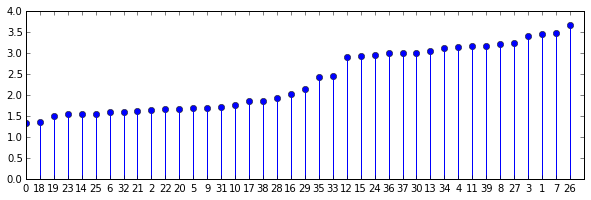

In [268]:
plt.figure(figsize=(10,3));
plt.stem(np.sort(d));
plt.gca().set_xticks(range(len(d)));
plt.gca().set_xticklabels(np.argsort(d));

In [15]:
# lm1 = [(1, 2), (3, 30), (4, 30), (5, 24), (6, 6), (7, 1)]
# lm2 = [(6, 31), (7, 18), (10, 1), (11, 3),(3,8),(4,8),(5,7)]
lm1 = [(5, 0),
 (6, 0),
 (7, 23),
 (8, 25),
 (9, 22),
 (11, 0),
 (12, 25),
 (13, 22),
 (14, 25),
 (15, 25),
 (16, 25),
 (17, 25),
 (18, 27),
 (19, 0),
 (20, 0),
 (21, 21),
 (22, 13),
 (23, 23),
 (24, 4)]

lm2 = [
    (18,5),
    (19,9),
    (20,19),
(21,28),
 (22,2),
 (23,29),
 (24,1)]

# test = [(10,25)]
# test = [(12,22)]
test = [(25,0)]

OUTPUT = False

dm_test = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=test[0][0])
boundary_test = dm_test.load_pipeline_result('boundaryModels', 'pkl')[test[0][1]]
sc_test = dm_test.load_pipeline_result('shapeContext', 'pkl')[test[0][1]]

internal_sps = dm_test.load_pipeline_result('internalSps', 'pkl')[test[0][1]]
texton_hists = dm_test.load_pipeline_result('texHist', 'npy')

X_test = []
for s in internal_sps:
    X_test.append(texton_hists[s])


scores1 = []
scores1_int = []
scores1_ext = []
scores1_shape = []
scores2 = []
scores2_int = []
scores2_ext = []
scores2_shape = []

X = []
Y = []

for sec_ind, lm_ind in lm1:
    dm_atlas = DataManager(generate_hierarchy=False, stack='RS140', resol='x5', section=sec_ind)
    boundary_atlas = dm_atlas.load_pipeline_result('boundaryModels', 'pkl')[lm_ind]
    sc_atlas = dm_atlas.load_pipeline_result('shapeContext', 'pkl')[lm_ind]
    s1, s1_int, s1_ext, s1_shape, _ = boundary_distance(boundary_test, boundary_atlas, sc_test, sc_atlas)
    
    internal_sps = dm_atlas.load_pipeline_result('internalSps', 'pkl')[lm_ind]
    texton_hists = dm_atlas.load_pipeline_result('texHist', 'npy')
    
    for s in internal_sps:
        X.append(texton_hists[s])
        Y.append(1)
    
    print sec_ind, lm_ind, s1
    scores1.append(s1)
    scores1_int.append(s1_int)
    scores1_ext.append(s1_ext)
    scores1_shape.append(s1_shape)


print '\n'

for sec_ind, lm_ind in lm2:
    dm_atlas = DataManager(generate_hierarchy=False, stack='RS140', resol='x5', section=sec_ind)
    boundary_atlas = dm_atlas.load_pipeline_result('boundaryModels', 'pkl')[lm_ind]
    sc_atlas = dm_atlas.load_pipeline_result('shapeContext', 'pkl')[lm_ind]
    s2, s2_int, s2_ext, s2_shape, _ = boundary_distance(boundary_test, boundary_atlas, sc_test, sc_atlas)
    
    internal_sps = dm_atlas.load_pipeline_result('internalSps', 'pkl')[lm_ind]
    texton_hists = dm_atlas.load_pipeline_result('texHist', 'npy')

    for s in internal_sps:
        X.append(texton_hists[s])
        Y.append(-1)

    print sec_ind, lm_ind, s2
    scores2.append(s2)
    scores2_int.append(s2_int)
    scores2_ext.append(s2_ext)
    scores2_shape.append(s2_shape)

print '\n'
# print np.mean([s for s in scores1 if s < np.inf]), np.mean([s for s in scores2 if s < np.inf])
# print np.mean([s for s in scores1_int if s < np.inf]), np.mean([s for s in scores2_int if s < np.inf])
# print np.mean([s for s in scores1_ext if s < np.inf]), np.mean([s for s in scores2_ext if s < np.inf])
# print np.mean([s for s in scores1_shape if s < np.inf]), np.mean([s for s in scores2_shape if s < np.inf])

print np.min([s for s in scores1 if s < np.inf]), np.min([s for s in scores2 if s < np.inf])
print np.mean([s for s in scores1_int if s < np.inf]), np.mean([s for s in scores2_int if s < np.inf])
print np.mean([s for s in scores1_ext if s < np.inf]), np.mean([s for s in scores2_ext if s < np.inf])
print np.mean([s for s in scores1_shape if s < np.inf]), np.mean([s for s in scores2_shape if s < np.inf])


5 0 inf
6 0 2.38825475179
7 23 2.18039871461
8 25 2.03555492536
9 22 2.34868187981
11 0 2.34148332228
12 25 2.14167806152
13 22 2.13054488473
14 25 2.14956197974
15 25 2.09640593278
16 25 2.26450329382
17 25 2.05240911478
18 27 2.2638353868
19 0 2.02936301294
20 0 2.07570329984
21 21 1.82703866019
22 13 1.62298520537
23 23 1.95682914139
24 4 1.54916598549


18 5 1.84742373044
19 9 2.05717828544
20 19 1.88376680356
21 28 2.30416522295
22 2 2.14912324251
23 29 2.28556498595
24 1 2.30492380173


1.54916598549 1.84742373044
0.312160889733 0.413379912052
1.52619860207 1.44979882224
0.242440372268 0.255699276077


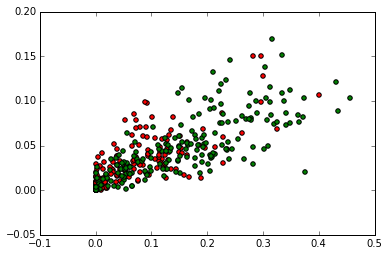

In [7]:
X = np.array(X)
Y = np.array(Y)

plt.scatter(X[:200, 2], X[:200, 5], c='r');
plt.scatter(X[-200:, 2], X[-200:, 5], c='g');

In [131]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)
p = clf.predict(X_test)
print len(np.where(p == 1)[0])/float(len(X_test))
# clf.predict_proba(X_test)

0.805555555556


In [10]:
from sklearn.externals.six import StringIO  
import pydot 
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("/tmp/iris.pdf") 

NameError: name 'tree' is not defined

In [130]:
from sklearn.svm import SVC, LinearSVC
# svc = SVC()
svc = SVC(kernel='poly', degree=2)
svc.fit(X, Y)

svc.predict(X)

svc.predict(X_test)

svc.decision_function(X_test)

array([[ 0.99991367],
       [ 0.99946708],
       [ 0.99929557],
       [ 0.99973314],
       [ 0.99959072],
       [ 0.99983609],
       [ 0.99982969],
       [ 0.99947951],
       [ 0.99954934],
       [ 0.99979456],
       [ 0.99963277],
       [ 0.9999782 ],
       [ 0.99959998],
       [ 0.99977883],
       [ 0.9996704 ],
       [ 0.99973908],
       [ 0.99958799],
       [ 0.99978257],
       [ 0.99956755],
       [ 1.00000955],
       [ 0.99977741],
       [ 0.99932964],
       [ 0.99987332],
       [ 0.99920895],
       [ 0.99980783],
       [ 0.9996844 ],
       [ 0.99961873],
       [ 0.99924241],
       [ 0.99974371],
       [ 0.99979786],
       [ 0.99993166],
       [ 0.99974001],
       [ 0.99977958],
       [ 0.99969047],
       [ 1.00010609],
       [ 0.99969057]])